# Review Classification
- ***David Atkins***

### Imports / Data Prep

In [2]:
import pandas as pd
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

# Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [3]:
%load_ext autoreload
%autoreload 2

import functions as fn

In [4]:
fpath = 'Data-NLP/processed-reviews-hoover.joblib'
df = joblib.load(fpath)
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,rated,tweet_token,spacy_lemmas,joined_token,joined_lemmas
0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"a guilty pleasure for me personally, as i love...",9.0,HIGH,"[a, guilty, pleasure, for, me, personally, ,, ...","[guilty, pleasure, personally, love, great, es...","a guilty pleasure for me personally , as i lov...",guilty pleasure personally love great escape w...
1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"the first underwhelmed me, but this one straig...",3.0,LOW,"[the, first, underwhelmed, me, ,, but, this, o...","[underwhelme, straight, bore, course, see, hun...","the first underwhelmed me , but this one strai...",underwhelme straight bore course see hunt clim...
2,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,after quite entertainign mission impossible i ...,2.0,LOW,"[after, quite, entertainign, mission, impossib...","[entertainign, mission, impossible, second, in...",after quite entertainign mission impossible i ...,entertainign mission impossible second install...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       2419 non-null   object 
 1   movie_id        2419 non-null   int64  
 2   imdb_id         2419 non-null   object 
 3   original_title  2419 non-null   object 
 4   review          2419 non-null   object 
 5   rating          2419 non-null   float64
 6   rated           2419 non-null   object 
 7   tweet_token     2419 non-null   object 
 8   spacy_lemmas    2419 non-null   object 
 9   joined_token    2419 non-null   object 
 10  joined_lemmas   2419 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.0+ KB


In [10]:
# verifying my previous data prep had removed the reviews without ratings
df['rating'].isna().sum()

0

In [11]:
df['rated'].value_counts()

LOW     1224
HIGH    1195
Name: rated, dtype: int64

In [12]:
# assign X and y
X = df['review']
y = df['rated']

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=42)

### Machine Learning Model

#### SKLEARN

In [14]:
# check class balance
y.value_counts(normalize=True)

LOW     0.505994
HIGH    0.494006
Name: rated, dtype: float64

In [15]:
## Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [16]:
# fit model pipeline
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00       888
         LOW       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



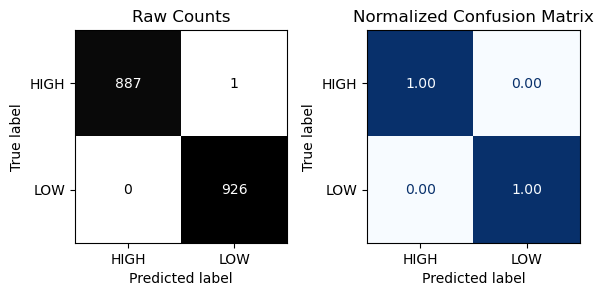


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        HIGH       0.83      0.85      0.84       307
         LOW       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



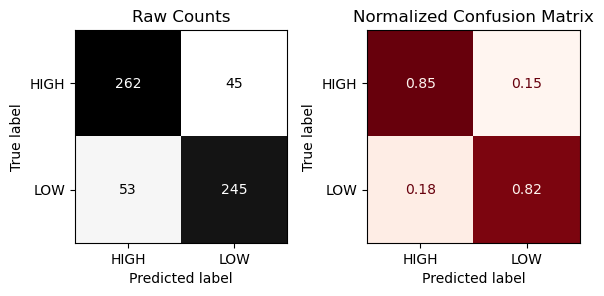

In [18]:
# evaluate model
fn.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

##### Observations: 
- This model has an accuracy of .84
- There is not a large difference in accuracy between classes

#### GridSearch Text Vectorization

In [19]:
# Define params to try
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    "vectorizer__min_df": [2,3,4],
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1,3)]
}

In [20]:
# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

In [21]:
# Set up Pipeline to allow GridSearching
vect_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier(random_state=42))])

In [22]:
%%time
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid_shared, cv=2, scoring = 'accuracy', verbose=1, n_jobs=-1)

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
%%time
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 162 candidates, totalling 324 fits
CPU times: total: 3.62 s
Wall time: 1min 10s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'vectorizer__max_df': [0.7, 0.8, 0.9],
                         'vectorizer__max_features': [None, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__stop_words': [None, 'english']},
             scoring='accuracy', verbose=1)

In [24]:
# what were the best params?
grid_search.best_params_

{'vectorizer__max_df': 0.7,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00       888
         LOW       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



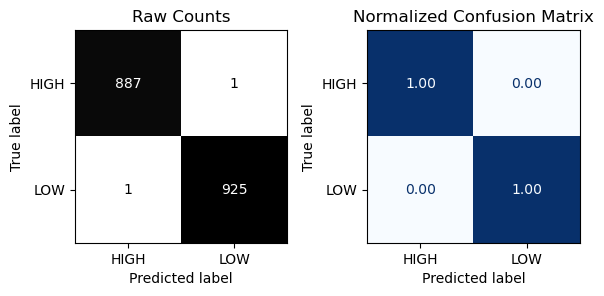


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        HIGH       0.83      0.83      0.83       307
         LOW       0.82      0.82      0.82       298

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



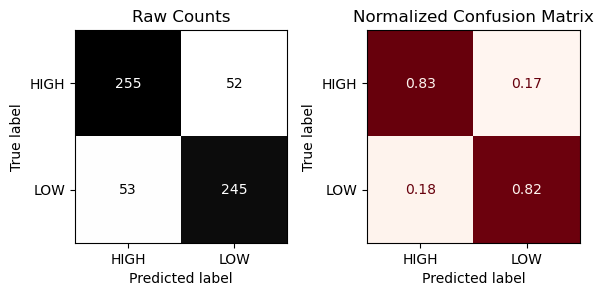

In [26]:
best_model = grid_search.best_estimator_

fn.evaluate_classification(best_model,X_train,y_train,X_test,y_test)

##### Observations: 
- With best parameters the gridsearch an accuracy of .83

### Deep NLP

#### Prep / Train Dataset

In [27]:
# instantiate LabelEncoder
encoder = LabelEncoder()

In [28]:
# Fit and Transform the strings into integers
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
dtype: int64

In [29]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [30]:
# shuffle data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [31]:
# Add a column to the dataframe that has the length of each paragraph
df['sequence_length'] = df['review'].map( lambda x: len(x.split(" ")))

In [32]:

df['sequence_length'].describe()

count    2419.000000
mean      225.767673
std       270.815728
min         1.000000
25%        62.000000
50%       143.000000
75%       286.500000
max      4017.000000
Name: sequence_length, dtype: float64

In [33]:
# maximum length = sequence length max
SEQUENCE_LENGTH = 4017

In [34]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

In [35]:
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [36]:
# Set the batch size
BATCH_SIZE =32

In [37]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [38]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

#### Creating Keras Text Vectorization Layer

In [39]:
# Create keras text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [40]:
# Fit/Adapt the text vectorization layer on the training texts.
sequence_vectorizer.adapt(ds_texts)

In [41]:
# Save the vocabulary size from the layer to use in your models' Embedding layer.
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [42]:
# unique classes
classes = y.unique()
classes

array([0, 1])

#### RNN

In [43]:
# Function - using the model that performed best in core projects
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    gru_model_bi_pool.add(layers.Dropout(.2))
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(64, return_sequences = True)))
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [ ]:
EMBED_DIM = 100
#Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=fn.get_callbacks(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 4017)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 4017, 100)         2492300   
                                                                 
 bidirectional (Bidirectiona  (None, 4017, 128)        63744     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 4017, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4017, 128)        74496     
 nal)                                                            
                                                        

In [ ]:
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

##### Observations: 
- Test data accuracy was <will insert this later, running the model is taking too much time
- Evaluation / comparison of classes